In [18]:
import json
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, RepeatedKFold, cross_val_score
from readability import Readability
import nltk
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext autotime
%matplotlib inline

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 54 ms


In [26]:
patent_descriptions_df = pd.read_csv("patent_descriptions.csv", index_col=0)

time: 11.8 s


In [27]:
decisions_df = pd.read_csv("ptab2_decisions.csv")

time: 540 ms


/Users/JasonKatz/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,9,11,12,13,14,15,16,17,19,20,21,22,23,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
proceedings_df = pd.read_csv("ptab2_proceedings.csv")

time: 284 ms


In [29]:
ignore_categories = ['Administrative Remand', 'Affirmed', 'Affirmed and Remanded', 'Affirmed with New Ground of Rejection   ', 
                'Affirmed with new ground of rejection   ', 'Affirmed-in-Part', 'Affirmed-in-Part and Remanded', 
                'Affirmed-in-part and remanded with new ground of rejection   ', 'Affirmed-in-part with new ground of rejection  ', 
                'Inter partes reexam affirmed', 'Inter partes reexam affirmed-in-part', 'Inter partes reexam new ground of rejection', 
                'Inter partes reexam rehearing decision is a new decision', 'Inter partes reexam remand ', 'Inter partes reexam reversed', 
                'Panel Remand', 'Reexam affirmed', 'Reexam affirmed-in-part', 'Reexam affirmed-in-part with new ground of rejection  ', 
                'Reexam rehearing decision final and appealable', 'Reexam rehearing decision is a new decision', 'Reexam reversed', 
                'Request for Adverse Judgment after Institution', 'Request for Adverse Judgment before Institution', 'Reversed', 
                'Reversed and Remanded', 'Reversed with New Ground of Rejection  ', 'Reversed with new ground of rejection  ', 'Vacated', 
                'Vacated and Remanded', 'Vacated with new ground of rejection   ', 'Vacated-in-Part', 'Termination']

good_claim_categories = ['Denied (Patent Owner)', 'Final Decision', 'Final decision', 'Granted', 'Granted (Patent Owner)', 'Granted (Petitioner)', 
                         'Granted-In-Part', 'Granted-in-Part (Patent Owner)', 'Granted-in-Part (Petitioner)', 'Settlement', 'Settlement after Institution', 
                         'Dismissed after Institution']

bad_claim_categories = ['Decision on Petition - Denied', 'Denied (Petitioner)', 'Dismissed', 'Dismissed before Institution', 
                        'Institution Denied', 'Settlement before Institution']

time: 38.3 ms


In [30]:
decisions_df = decisions_df[~decisions_df['subdecision_type_category'].isin(ignore_categories)]

time: 41.5 ms


In [31]:
decisions_df['good_claim'] = decisions_df['subdecision_type_category'].isin(good_claim_categories).astype(int)

time: 834 ms


In [32]:
training_data = pd.DataFrame()

time: 1.77 ms


In [33]:
training_data['proceeding_number'] = decisions_df['proceeding_number']
training_data['patent_id'] = decisions_df['respondent_patent_number']
training_data['technology_center'] = decisions_df['respondent_technology_center_number']
training_data['good_claim'] = decisions_df['good_claim']

time: 9.79 ms


In [97]:
training_data = training_data.merge(patent_descriptions_df, on="patent_id", how="left")

time: 2.92 s


In [98]:
training_data = training_data.merge(proceedings_df[['proceeding_number', 'accorded_filing_date', 'respondent_grant_date']], on="proceeding_number", how="left").dropna()

time: 88.3 ms


In [99]:
training_data['accorded_filing_date'] = pd.to_datetime(training_data['accorded_filing_date'])
training_data['respondent_grant_date'] = pd.to_datetime(training_data['respondent_grant_date'])
training_data['days_between_grant_and_filing'] = (training_data['accorded_filing_date'] - training_data['respondent_grant_date']).dt.days.astype('int16')

time: 522 ms


In [36]:
training_data['description_word_count'] = training_data['detailed_description'].str.split().str.len()

KeyError: 'detailed_description'

time: 311 ms


In [106]:
training_data = pd.get_dummies(training_data, columns=['technology_center'])

time: 33.2 ms


In [95]:
# training_data.to_csv("training_data.csv")

time: 15.5 s


In [118]:
X = training_data.iloc[:,6:]
X = training_data[['days_between_grant_and_filing', 'description_word_count', 'fk_score', 'fig_counts']]
y = training_data['good_claim']

time: 439 ms


In [119]:
model = GradientBoostingClassifier(learning_rate=.1, n_estimators=100, max_depth=5, subsample=1, min_samples_split=2, random_state=33)
# model = RandomForestClassifier(n_estimators=50, random_state=33, max_depth=3, min_samples_split=2, max_features="sqrt")
# model = LogisticRegression()
# model = DecisionTreeClassifier()
# model = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
cv_results = cross_validate(model, X, y, cv=RepeatedKFold(n_splits=7, n_repeats=3, random_state=7), n_jobs=-1, return_train_score=True, 
                            scoring=['accuracy', 'neg_log_loss'])

time: 16.8 s


In [120]:
print("Accuracy: {}".format(cv_results['test_accuracy'].mean()))
print("Log Loss: {}".format(-cv_results['test_neg_log_loss'].mean()))

Accuracy: 0.7422466545868435
Log Loss: 0.5434979089880754
time: 49.4 ms


In [256]:
print("Accuracy: {}".format(cv_results['test_accuracy'].mean()))
print("Log Loss: {}".format(-cv_results['test_neg_log_loss'].mean()))

Accuracy: 0.7458920179320401
Log Loss: 0.5375062279500918
time: 3.59 ms


In [258]:
print("Naive Accuracy: {}".format(y.mean()))
print("Naive Log Loss: {}".format(log_loss(y, [y.mean()]*len(y))))

Naive Accuracy: 0.7109751575824991
Naive Log Loss: 0.6012762313064095
time: 11.3 ms


In [75]:
training_data = pd.read_csv("training_data.csv", index_col=0)

time: 5.38 s


In [5]:
training_data.shape

(5394, 22)

time: 5.72 ms


In [74]:
training_data['good_claim'].mean()

0.7109751575824991

time: 12.8 ms


In [117]:
training_data.head()

,proceeding_number,patent_id,good_claim,detailed_description,accorded_filing_date,respondent_grant_date,days_between_grant_and_filing,technology_center_1200,technology_center_1600,technology_center_1700,...,technology_center_2700,technology_center_2800,technology_center_3600,technology_center_3700,technology_center_3900,technology_center_ODM,technology_center_OPIM,description_word_count,fk_score,fig_counts
0,PGR2018-00008,9597594,0,"DESCRIPTION Hereinafter, with reference to the...",2017-11-07,2017-03-21,231,0,0,0,...,0,0,0,1,0,0,0,13494,13.314722,69
1,IPR2018-01566,8367337,1,"As discussed herein, the present invention pro...",2018-08-21,2013-02-05,2023,0,1,0,...,0,0,0,0,0,0,0,7893,19.433383,8
2,IPR2019-00015,8409052,0,DESCRIPTION OF THE PREFERRED EMBODIMENT An exe...,2018-10-31,2013-04-02,2038,0,0,0,...,0,0,1,0,0,0,0,4224,14.952263,17
3,IPR2018-00159,9023979,1,DESCRIPTION OF SPECIFIC EMBODIMENTS Hereinafte...,2017-11-10,2015-05-05,920,0,0,1,...,0,0,0,0,0,0,0,9089,20.703933,7
4,IPR2017-02108,8508751,1,DETAILED DESCRIPTION OF THE EMBODIMENTS With r...,2017-09-15,2013-08-13,1494,0,0,0,...,0,0,0,0,0,0,0,2446,15.367966,11


time: 385 ms


In [90]:
clinical_trial_counts = []
bio_similar_counts = []
biologic_counts = []
fig_counts = []
patent_references = []
for description in training_data['detailed_description']:
    description = description.lower()
    clinical_trial_counts.append(description.count("clinical trial"))
    bio_similar_counts.append(description.count("bio-similar"))
    biologic_counts.append(description.count("biologic"))
    fig_counts.append(description.count("fig.") + description.count("figs."))
    patent_references.append(description.count("pat. no."))

time: 4.44 s


In [231]:
# X['patent_references'] = patent_references -- might help
# X['fig_counts'] = fig_counts
# X['clinical_trial_counts'] = clinical_trial_counts
# X['bio_similar_counts'] = bio_similar_counts

time: 6.76 ms


In [ ]:
import pandas as pd
from readability import Readability
import sys
import csv
csv.field_size_limit(sys.maxsize)

In [ ]:
description_features = {}
with open("detail_description_data/detail-desc-text-{}.tsv".format(sys.argv[1]),'r') as tsvin:
    tsvin = csv.reader(tsvin, delimiter='\t')
    for row in tsvin:
        patent_id = row[0]
        detail_description_text = row[1]
        try:
            description_word_count = len(detail_description_text.split())
            fig_counts = detail_description_text.count("fig.") + detail_description_text.count("figs.")
            r = Readability(detail_description_text.replace('aed-512', ''))
            fk_score = r.flesch_kincaid().score
        except:
            continue
        description_features[patent_id] = (description_word_count, fk_score, fig_counts)
with open("probability_data/description_features_{}.json".format(sys.argv[1]), 'w') as f:
    json.dump(description_features, f)

In [ ]:
import pandas as pd
patent = pd.read_csv("patent.tsv", sep="\t", error_bad_lines=False)
patent['now'] = pd.to_datetime('now')
patent['date'] = pd.to_datetime(patent['date'], errors='coerce')
patent = patent[patent['date'].between('1800-01-01', pd.datetime.today())]
patent['days_between_grant_and_filing'] = (patent['now'] - patent['date']).dt.days.astype('int16') 
patent[['id', 'days_between_grant_and_filing']].to_csv("patent_days_between.csv")

/Users/JasonKatz/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/JasonKatz/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/Users/JasonKatz/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


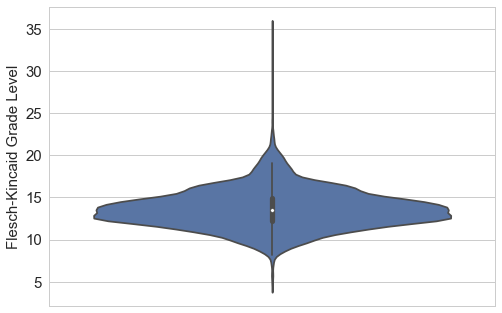

time: 239 ms


In [73]:
sns.set(style="whitegrid")
plot = sns.violinplot(y=training_data['fk_score'])
plot.set_ylabel("Flesch-Kincaid Grade Level",fontsize=15)
plot.tick_params(labelsize=15)

/Users/JasonKatz/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/JasonKatz/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/Users/JasonKatz/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


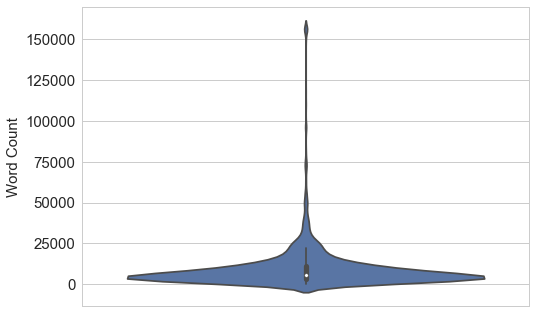

time: 283 ms


In [72]:
sns.set(style="whitegrid")
plot = sns.violinplot(y=training_data['description_word_count'])
plot.set_ylabel("Word Count",fontsize=15)
plot.tick_params(labelsize=15)

/Users/JasonKatz/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/JasonKatz/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)
/Users/JasonKatz/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


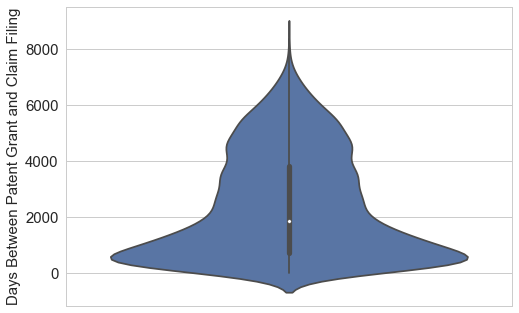

time: 171 ms


In [25]:
sns.set(style="whitegrid")
plot = sns.violinplot(y=training_data['days_between_grant_and_filing'])
plot.set_ylabel("Days Between Patent Grant and Claim Filing",fontsize=15)
plot.tick_params(labelsize=15)

In [ ]:
tech_perc = training_data[training_data['technology_center'].isin(['3700', '1600', '3600', '1700', '2600', '2100', '2800', '2400'])].groupby('technology_center').mean()

/Users/JasonKatz/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Technology Center Good Claim Percentages (Top 8)')

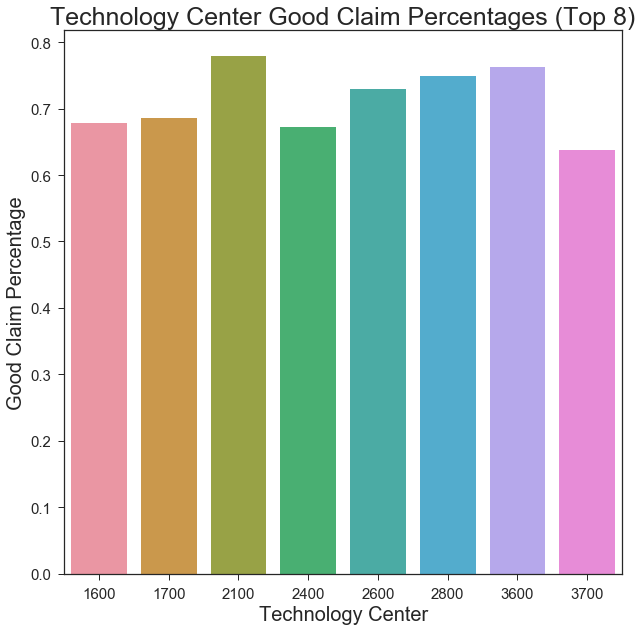

time: 352 ms


In [69]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(10, 10))
plot = sns.barplot(np.array(['3700', '1600', '3600', '1700', '2600', '2100', '2800', '2400']),tech_perc['good_claim'])
plot.set_xlabel("Technology Center" ,fontsize=20)
plot.set_ylabel("Good Claim Percentage",fontsize=20)
plot.tick_params(labelsize=15)
plot.set_title("Technology Center Good Claim Percentages (Top 8)", fontsize=25)

/Users/JasonKatz/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Technology Center Frequencies (Top 8)')

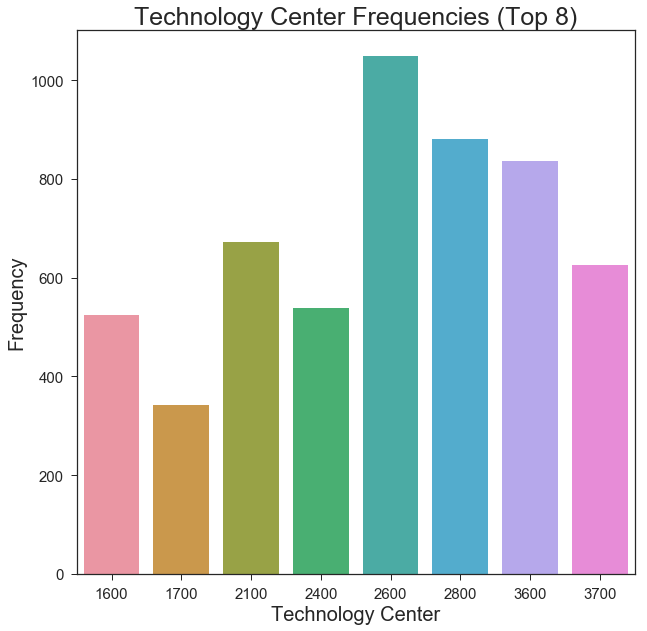

time: 299 ms


In [67]:
sns.set(style="ticks")
f, ax = plt.subplots(figsize=(10, 10))
plot = sns.countplot(training_data[training_data['technology_center'].isin(['3700', '1600', '3600', '1700', '2600', '2100', '2800', '2400'])]['technology_center'])
plot.set_xlabel("Technology Center" ,fontsize=20)
plot.set_ylabel("Frequency",fontsize=20)
plot.tick_params(labelsize=15)
plot.set_title("Technology Center Frequencies (Top 8)", fontsize=25)